# Notes

1- Do i need to explain that I created point and line string for missing geometries?

8- For task c do we need to create a new graph with the amendments to get path of 42 KM?

9- I have check if any of the cells have 42 km and none of them have even when I decrease the number of seeds or initial points

10- For Task D, do we need to show a diagram with full details such as the one in this link: https://www.w3.org/TR/prov-o/ or a simple diagram like this https://www.w3.org/TR/2013/NOTE-prov-primer-20130430/

11- Can I write the report as 2 columns document?


# Import Libraries

In [159]:
import matplotlib.pyplot as plt
import networkx as nx
import folium
import seaborn as sns
import osmnx as ox
import random 

import os

from geopandas import GeoDataFrame
from shapely.geometry import Point, LineString, Polygon
import pyproj

import spaghetti

import pandas as pd
import numpy as np

import esda

from sklearn.cluster import KMeans

## Import accidents into a dataframe

In [160]:
# Function that takes a path and download all files in that path to a dataframe
def download_files(path):
    # Create a list of all files in the path
    files = os.listdir(path)
    # Create an empty dataframe
    df = pd.DataFrame()
    # Loop through all files in the path
    for file in files:
        # Read the file to a dataframe
        temp = pd.read_csv(path + file)
        # Append the dataframe to the empty dataframe
        df = df.append(temp)
    # Return the dataframe
    return df

        

In [161]:
leeds_accidents = download_files("Data/")
leeds_accidents.shape

(6105, 22)

### Transform the coordinates of british national grid

In [162]:
# Define the input projection as British National Grid
input_proj = pyproj.Proj('epsg:27700')

# Define the output projection as WGS84 (longitude and latitude)
output_proj = pyproj.Proj('epsg:4326')

# Convert the Easting and Northing coordinates to longitude and latitude
leeds_accidents['longitude'], leeds_accidents['latitude'] = pyproj.transform(input_proj, output_proj, leeds_accidents['Grid Ref: Easting'], leeds_accidents['Grid Ref: Northing'])


/var/folders/pz/y4y03t6d7cd_76njhx8sjzzm0000gn/T/ipykernel_7178/1127791686.py:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  leeds_accidents['longitude'], leeds_accidents['latitude'] = pyproj.transform(input_proj, output_proj, leeds_accidents['Grid Ref: Easting'], leeds_accidents['Grid Ref: Northing'])


### Check for missing values for location

In [163]:
# check if there is missing values in Grid Ref: Easting and Grid Ref: Northing
easting = leeds_accidents['Grid Ref: Easting'].isnull().sum()
northing = leeds_accidents['Grid Ref: Northing'].isnull().sum()

# check if there is missing values in longitude and latitude
long = leeds_accidents['longitude'].isnull().sum()
lat = leeds_accidents['latitude'].isnull().sum()

print("There are {} missing values in Easting and {} missing values in Northing".format(easting, northing))
print("There are {} missing values in longitude and {} missing values in latitude".format(long, lat))

There are 0 missing values in Easting and 0 missing values in Northing
There are 0 missing values in longitude and 0 missing values in latitude


### Drop accidents that have missing Longitude/Latitude

In [164]:
# Create a new dataframe with only the longitude and latitude columns
leeds_accidents_locations = leeds_accidents[['longitude','latitude']]

# Some accidents do not record a location, so drop any that have 'NaN' for the longitude or latitude
located_accidents = leeds_accidents_locations.dropna(subset=['longitude', 'latitude'])
print("Total no. of located accidents filtered: {}".format(len(located_accidents)))

Total no. of located accidents filtered: 6105


## Get area of interest

In [165]:
# Create a query to get the area of interest
leeds_query = 'Leeds City Centre, Leeds, United Kingdom'

leeds_area = ox.geocode_to_gdf(leeds_query, buffer_dist=1000)

### Get the coordinates of the area

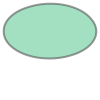

In [166]:
# Get the geometry of the polygon chosen
leeds_polygon = leeds_area['geometry'][0]
leeds_polygon

### create a geodataframe for the points of Long and Lat

In [167]:
# Translate to a GeoDatFrame where the geometry is given by a Point constructed from the longitude and latitude
accident_points = GeoDataFrame(geometry=[Point(xy) for xy in zip(
    leeds_accidents_locations.latitude, leeds_accidents_locations.longitude)])

accident_points

geometry
0     POINT (-1.48679 53.75513)
1     POINT (-1.54485 53.80029)
2     POINT (-1.54485 53.80029)
3     POINT (-1.54485 53.80029)
4     POINT (-1.54485 53.80029)
...                         ...
6100  POINT (-1.36229 53.80617)
6101  POINT (-1.65171 53.83463)
6102  POINT (-1.44093 53.87753)
6103  POINT (-1.67556 53.80185)
6104  POINT (-1.67556 53.80185)

[6105 rows x 1 columns]

### Filter accidents based on area chosen and print the total number of filtered accidents

In [168]:
# filter accidents that are within the boundries of the map
accident_points = accident_points[accident_points.within(leeds_polygon)]
print("Total no. of located accidents filtered: {}".format(len(accident_points)))

Total no. of located accidents filtered: 379


## Create a graph from the area chosen with network_type as drive

In [169]:
# create a graph from the polygon with the drive network type
leeds_graph = ox.graph_from_polygon(leeds_polygon, network_type='drive')

In [170]:
# get the area of the polygon
leeds_area = ox.project_gdf(leeds_area).unary_union.area

# get the basic stats of the graph with the area chosen
ox.basic_stats(leeds_graph, area=leeds_area)

{'n': 715,
 'm': 1652,
 'k_avg': 4.620979020979021,
 'edge_length_total': 109170.77000000003,
 'edge_length_avg': 66.08400121065377,
 'streets_per_node_avg': 2.6895104895104893,
 'streets_per_node_counts': {0: 0, 1: 152, 2: 14, 3: 456, 4: 90, 5: 3},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.2125874125874126,
  2: 0.019580419580419582,
  3: 0.6377622377622377,
  4: 0.1258741258741259,
  5: 0.004195804195804196},
 'intersection_count': 563,
 'street_length_total': 61383.27299999998,
 'street_segment_count': 926,
 'street_length_avg': 66.28863174946002,
 'circuity_avg': 1.0282180128376803,
 'self_loop_proportion': 0.0,
 'node_density_km': 213.51895514844566,
 'intersection_density_km': 168.1275129350698,
 'edge_density_km': 32601.438801610184,
 'street_density_km': 18330.758481890614}

### Spatial diameter of the network

In [171]:
# Get the diameter of the graph
print(ox.extended_stats(leeds_graph, ecc=True)['diameter'])

/Users/mohammadmaraqa/opt/anaconda3/envs/nda/lib/python3.9/site-packages/osmnx/stats.py:458: UserWarning: The extended_stats function has been deprecated and will be removed in a future release. Use NetworkX directly for extended topological measures.
  warnings.warn(msg)


3804.313


## Check if there is any missing gemoetry and add one if missing

In [172]:
x_values = nx.get_node_attributes(leeds_graph, 'x')
y_values = nx.get_node_attributes(leeds_graph, 'y')

# We will work with the edges and add the missing geometries (lines denoting the roads between points)
graph_with_geometries = list(leeds_graph.edges(data=True))

# Iterate through the edges and, where missing, add a geometry attribute with the line between start and end nodes
for e in graph_with_geometries:
    if not 'geometry' in e[2]:
        e[2]['geometry'] = LineString([
            Point(x_values[e[0]], y_values[e[0]]),
            Point(x_values[e[1]], y_values[e[1]])])

graph_with_geometries[0:4]

[(9823138,
  8674727247,
  {'osmid': 491178802,
   'oneway': True,
   'lanes': '2',
   'ref': 'A61',
   'name': 'Regent Street',
   'highway': 'trunk',
   'maxspeed': '30 mph',
   'length': 75.411,
   'geometry': <shapely.geometry.linestring.LineString at 0x7f97bb116400>}),
 (9823138,
  52162260,
  {'osmid': 53014871,
   'oneway': True,
   'name': 'Byron Street',
   'highway': 'unclassified',
   'maxspeed': '20 mph',
   'length': 78.63,
   'geometry': <shapely.geometry.linestring.LineString at 0x7f95e02e4b80>}),
 (9823212,
  304904881,
  {'osmid': 23120678,
   'name': 'Skinner Lane',
   'highway': 'tertiary',
   'maxspeed': '30 mph',
   'oneway': False,
   'length': 11.47,
   'geometry': <shapely.geometry.linestring.LineString at 0x7f97bb064820>}),
 (9823212,
  395469503,
  {'osmid': 38422455,
   'oneway': True,
   'lanes': '2',
   'ref': 'A61',
   'name': 'Regent Street',
   'highway': 'trunk',
   'length': 67.194,
   'geometry': <shapely.geometry.linestring.LineString at 0x7f98d99692

In [173]:
# We will now drop the start and end nodes, as we will construct a new Spaghetti network based on the geometries of the roads
road_lines = [x[2] for x in graph_with_geometries]

# From this, we can construct a GeoDataFrame
roads_geodataframe = GeoDataFrame(pd.DataFrame(road_lines))
roads_geodataframe

osmid  oneway lanes  ref  \
0                             491178802    True     2  A61   
1                              53014871    True   NaN  NaN   
2                              23120678   False   NaN  NaN   
3                              38422455    True     2  A61   
4     [169591262, 440408598, 169591263]   False     2  NaN   
...                                 ...     ...   ...  ...   
1647                         1133776017    True   NaN  NaN   
1648                         1140215738   False   NaN  NaN   
1649                           23137264   False     2  NaN   
1650                           23091062   False     2  NaN   
1651                          149749869   False   NaN  NaN   

                     name       highway maxspeed   length  \
0           Regent Street         trunk   30 mph   75.411   
1            Byron Street  unclassified   20 mph   78.630   
2            Skinner Lane      tertiary   30 mph   11.470   
3           Regent Street         trunk      NaN   67.194   
4            Skinner Lane      tertiary   30 mph  208.128   
...                   ...           ...      ...      ...   
1647  Lascelles Road East   residential      NaN   10.172   
1648       Chapman Street  unclassified   20 mph    4.829   
1649           Cherry Row      tertiary   30 mph    4.397   
1650           Cherry Row      tertiary   30 mph  104.003   
1651      Mushroom Street  unclassified      NaN  151.062   

                                               geometry bridge junction access  
0     LINESTRING (-1.53312 53.80234, -1.53294 53.80301)    NaN      NaN    NaN  
1     LINESTRING (-1.53312 53.80234, -1.53321 53.802...    NaN      NaN    NaN  
2     LINESTRING (-1.53260 53.80366, -1.53276 53.80369)    NaN      NaN    NaN  
3     LINESTRING (-1.53260 53.80366, -1.53276 53.80306)    NaN      NaN    NaN  
4     LINESTRING (-1.53260 53.80366, -1.53252 53.803...    yes      NaN    NaN  
...                                                 ...    ...      ...    ...  
1647  LINESTRING (-1.51745 53.81399, -1.51741 53.813...    NaN      NaN    NaN  
1648  LINESTRING (-1.52390 53.80491, -1.52397 53.80490)    NaN      NaN    NaN  
1649  LINESTRING (-1.52867 53.80403, -1.52866 53.80407)    NaN      NaN    NaN  
1650  LINESTRING (-1.52867 53.80403, -1.52876 53.803...    NaN      NaN    NaN  
1651  LINESTRING (-1.52867 53.80403, -1.52919 53.804...    NaN      NaN    NaN  

[1652 rows x 12 columns]

## Check planarity of graph

In [174]:
# check if graph is planar or not
is_planar, Kuratowski_subgraphs = nx.check_planarity(leeds_graph, counterexample=True)

is_planar

True

## Check if there is any important attributes that have missing values

In [175]:
print(roads_geodataframe.shape)

#print null values
print(roads_geodataframe.isnull().sum())

(1652, 12)
osmid          0
oneway         0
lanes       1196
ref         1530
name          34
highway        0
maxspeed     972
length         0
geometry       0
bridge      1644
junction    1646
access      1649
dtype: int64


## plot the graph

In [176]:
ox.plot_graph_folium(leeds_graph)

### Construct a spaghetti network

In [177]:
# From the GeoDataFrame, we can construct a network in Spaghetti from which to do point analysis
leeds_points_graph = spaghetti.Network(in_data=roads_geodataframe)

<AxesSubplot:>

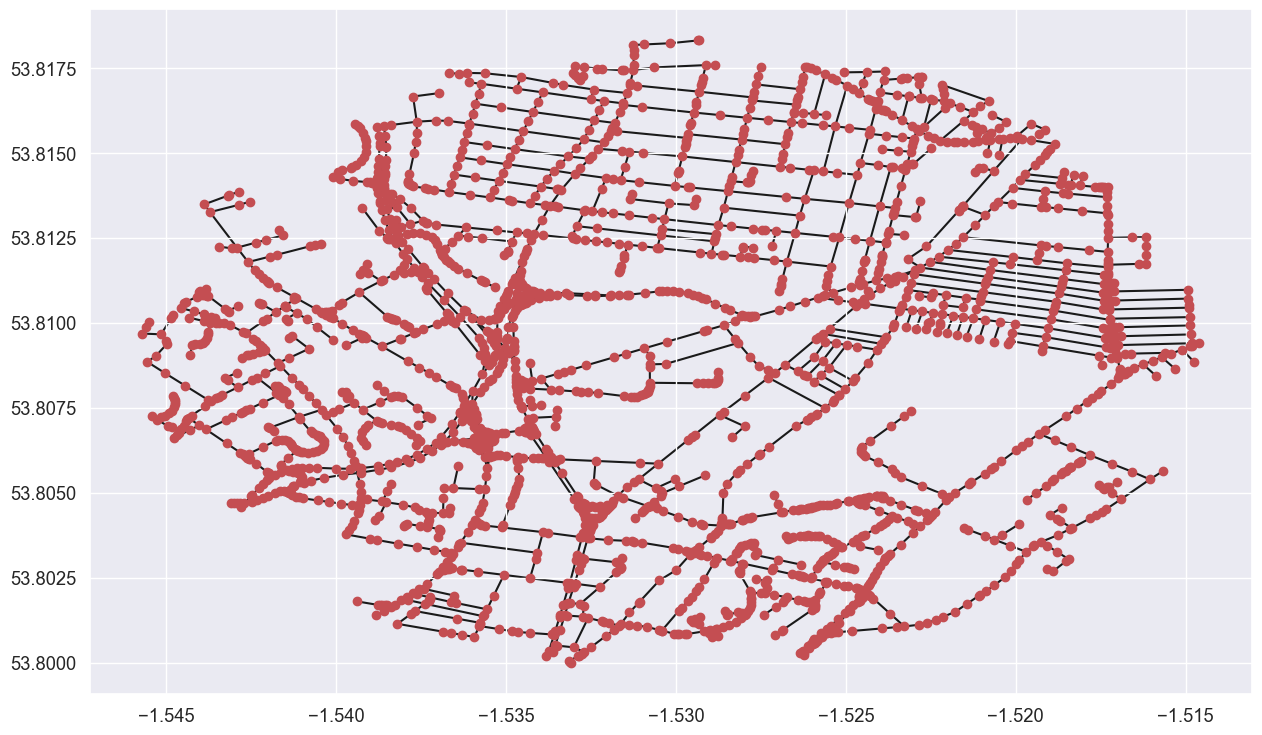

In [178]:
# Check what this new network looks like by getting DataFrames for the edges and plotting them
nodes_df, edges_df = spaghetti.element_as_gdf(
    leeds_points_graph, vertices=True, arcs=True)

base_network = edges_df.plot(color = "k", zorder=0, figsize=(15, 15))
nodes_df.plot(ax=base_network, color="r", zorder=2)

## Add accidents to the network

In [179]:
# We will now snap the leeds located accidents we extracted earlier, i.e. position them at the closest point on the closest road
leeds_points_graph.snapobservations(accident_points, 'accidents')

# We can see the difference between the original accidents coordinates and their position when snapped to the road network
print("observation 1\ntrue coords:\t%s\nsnapped coords:\t%s" % (
    leeds_points_graph.pointpatterns["accidents"].points[0]["coordinates"],
    leeds_points_graph.pointpatterns["accidents"].snapped_coordinates[0]
))

/Users/mohammadmaraqa/opt/anaconda3/envs/nda/lib/python3.9/site-packages/libpysal/cg/shapes.py:103: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
/Users/mohammadmaraqa/opt/anaconda3/envs/nda/lib/python3.9/site-packages/libpysal/cg/shapes.py:1006: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
/Users/mohammadmaraqa/opt/anaconda3/envs/nda/lib/python3.9/site-packages/libpysal/cg/shapes.py:1923: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)


observation 1
true coords:	(-1.5259572646176645, 53.800564140982566)
snapped coords:	(-1.5259464198961739, 53.80055044362781)


<AxesSubplot:>

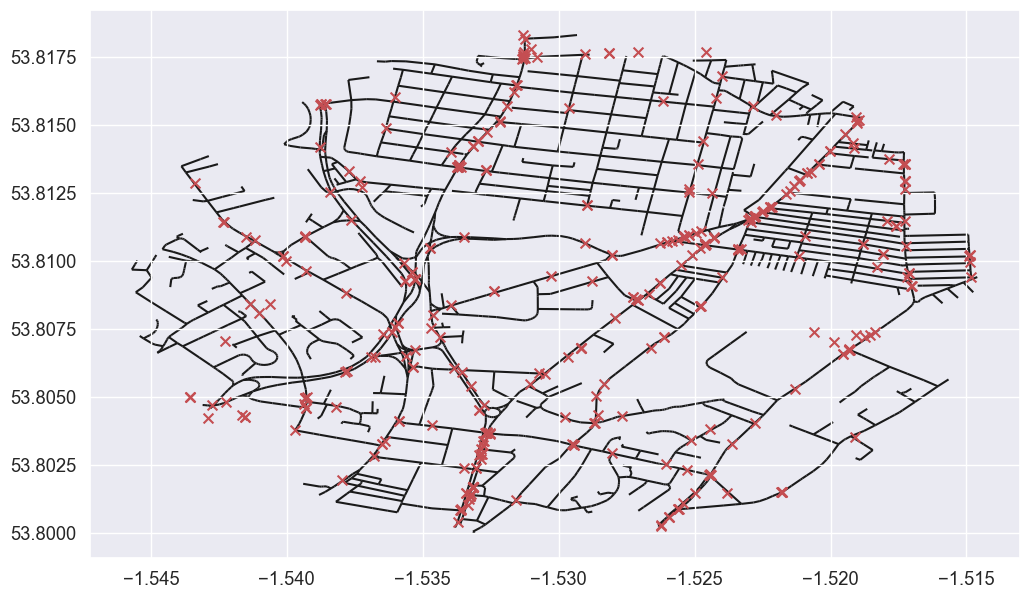

In [180]:
# Show the network with non-snapped (real) accidents
base_network = edges_df.plot(color="k", zorder=0, figsize =(12, 12))
# Get a GeoDataFrame of the non-snapped (real) accidents locations to plot on the net
observed_accidents=spaghetti.element_as_gdf(
    leeds_points_graph, pp_name='accidents', snapped=False)

# Plot these on the road network
observed_accidents.plot(
    color="r", marker="x",
    markersize=50, zorder=1, ax=base_network)

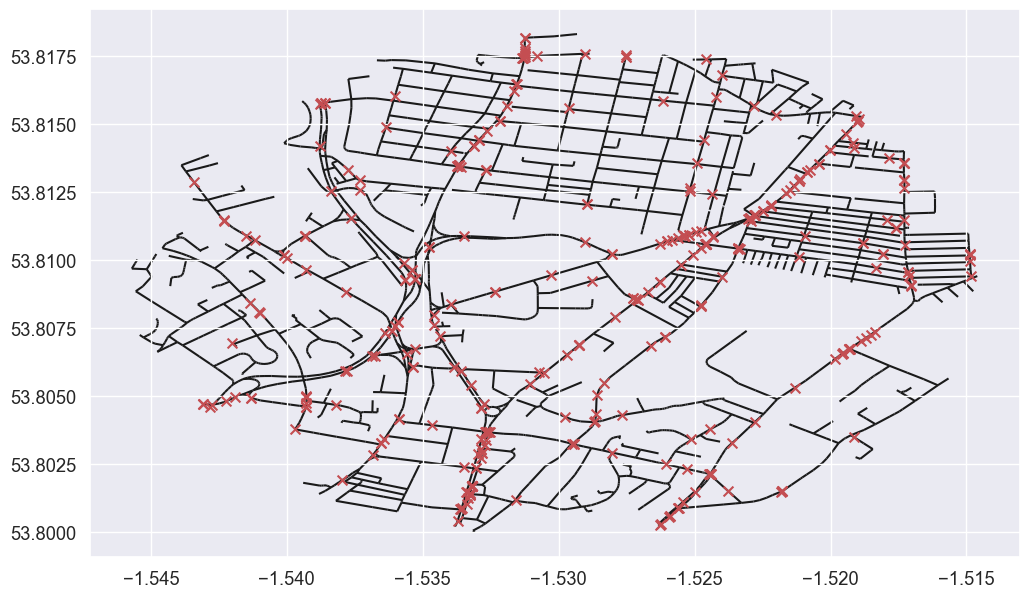

In [181]:
# Show the network
base_network = edges_df.plot(color="k", zorder=0, figsize =(12, 12))
snapped_accidents=spaghetti.element_as_gdf(
    leeds_points_graph, pp_name='accidents', snapped=True)

# Plot these on the road network
snapped_accidents.plot(
    color="r", marker="x",
    markersize=50, zorder=1, ax=base_network)

plt.show()

## Network Accidents Pattern Analysis - Autocorrelation

In [182]:
# Create K-function analysis
kres = leeds_points_graph.GlobalAutoK(leeds_points_graph.pointpatterns['accidents'], nsteps=50, permutations=100)

In [183]:
# Results of the K-function analysis
kres.lam
kres.xaxis
kres.observed
kres.upperenvelope
kres.lowerenvelope
kres.sim

print(f"Density of points in the network (lambda): {kres.lam}")

Density of points in the network (lambda): 501.5003223072631


In [184]:
print(f"Distances at which density is measured:\n{kres.xaxis}")

Distances at which density is measured:
[0.         0.00070583 0.00141166 0.00211749 0.00282332 0.00352916
 0.00423499 0.00494082 0.00564665 0.00635248 0.00705831 0.00776414
 0.00846997 0.00917581 0.00988164 0.01058747 0.0112933  0.01199913
 0.01270496 0.01341079 0.01411662 0.01482246 0.01552829 0.01623412
 0.01693995 0.01764578 0.01835161 0.01905744 0.01976327 0.0204691
 0.02117494 0.02188077 0.0225866  0.02329243 0.02399826 0.02470409
 0.02540992 0.02611575 0.02682159 0.02752742 0.02823325 0.02893908
 0.02964491 0.03035074 0.03105657 0.0317624  0.03246823 0.03317407
 0.0338799  0.03458573]


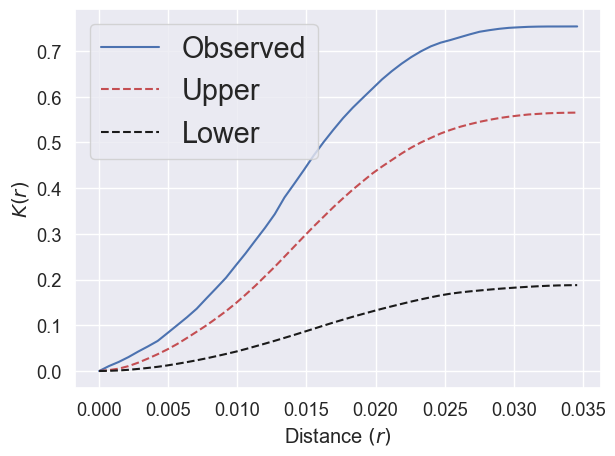

In [185]:
# Plot the results of the K-function analysis
fig, ax = plt.subplots()

ax.plot(kres.xaxis, kres.observed, "b-", label="Observed")
ax.plot(kres.xaxis, kres.upperenvelope, "r--", label="Upper")
ax.plot(kres.xaxis, kres.lowerenvelope, "k--", label="Lower")

ax.legend(loc="best", fontsize="x-large")
ax.set_xlabel("Distance $(r)$")
ax.set_ylabel("$K(r)$")

fig.tight_layout()

## Using Moran's l autocorrelation

In [186]:
# Create a point pattern object
pointpattern = leeds_points_graph.pointpatterns['accidents']

# Count the number of points per link
counts = leeds_points_graph.count_per_link(pointpattern.obs_to_arc, graph= False)

print(counts)

{(2292, 2293): 3, (1164, 1165): 2, (1204, 2313): 1, (1258, 1900): 1, (2300, 2301): 1, (1763, 1764): 2, (902, 905): 1, (221, 1164): 2, (653, 655): 1, (1900, 1901): 1, (1317, 1318): 2, (1770, 1774): 4, (144, 1269): 1, (1430, 2256): 1, (60, 337): 1, (2272, 2295): 1, (1100, 1863): 1, (59, 60): 3, (108, 109): 1, (326, 327): 3, (218, 219): 1, (82, 1931): 1, (64, 65): 1, (1098, 1777): 4, (490, 491): 1, (1181, 1182): 1, (55, 56): 2, (140, 141): 2, (637, 649): 1, (1314, 1346): 1, (872, 873): 2, (1594, 1595): 3, (0, 517): 2, (122, 125): 4, (1189, 1190): 1, (840, 841): 1, (1345, 1997): 2, (1165, 1166): 2, (1272, 1273): 1, (1193, 1194): 1, (118, 1338): 2, (829, 1268): 1, (125, 126): 3, (254, 437): 2, (1633, 1634): 1, (652, 702): 1, (100, 102): 1, (2312, 2313): 2, (752, 753): 1, (91, 92): 3, (1, 2331): 1, (1093, 1097): 1, (637, 638): 3, (116, 132): 3, (212, 213): 1, (1348, 1350): 1, (174, 2119): 1, (85, 87): 2, (92, 1763): 3, (80, 81): 1, (31, 276): 1, (755, 756): 1, (4, 7): 2, (1866, 1867): 1, (11

In [187]:
#check if there is count of 0 between two nodes in the dictionary
for key, value in counts.items():
    if value == 0:
        print(len(key), 'have value of 0')

In [188]:
# Get the weights of the Leeds network
weights = leeds_points_graph.w_network

In [189]:
# Get the edges of the network
edges = weights.neighbors.keys()

# Check if the edges are in the counts dictionary
values = [counts[edge] if edge in counts.keys () else 0. \
    for index, edge in enumerate(edges)]

In [190]:
# Create a Moran object with the values and weights of the network
moran = esda.moran.Moran(values, weights)

# Print the Moran's I value which is a measure of spatial autocorrelation
moran.I

0.13902456116793688

In [191]:
# Print the p-value of the Moran's I value to check our assumptions
moran.p_sim

0.001

In [192]:
# Print the expected value of the Moran's I value and its value under the null hypothesis
moran.EI
moran.EI_sim

print(moran.EI)

-0.00039277297721916735


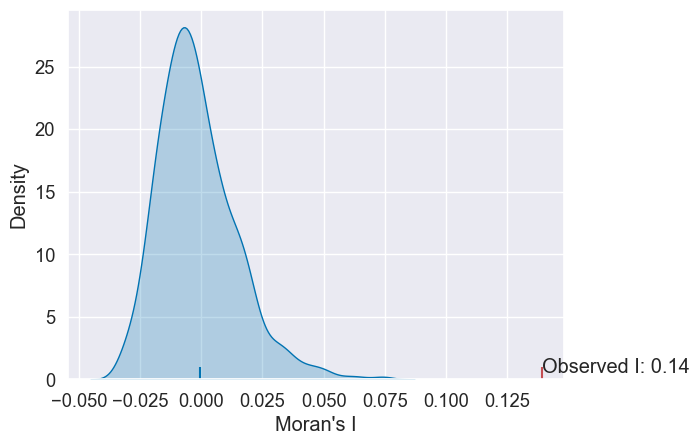

In [193]:
# Plot the distribution of the Moran's I values under the null hypothesis
sns.kdeplot(moran.sim, shade=True)
plt.vlines(moran.I, 0, 1, color='r')
plt.vlines(moran.EI, 0,1)
plt.xlabel("Moran's I")
plt.ylabel("Density")

# show the values of the observed and expected I
plt.text(moran.I, 0.5, f"Observed I: {moran.I:.2f}")
plt.show()

### Distribution of accidents away from intersections

[(0, ([315, 316], 3.504857459285353e-05)), (1, ([139], 0.00024066971369158266)), (2, ([64, 65], 5.492313114781456e-05)), (3, ([9], 9.482782859862905e-05)), (4, ([245], 0.0006101222198638884))]
The maximum distance:  0.0035124453313841167
The minimum distance:  0.0
The mean distance:  0.00028752355107903015


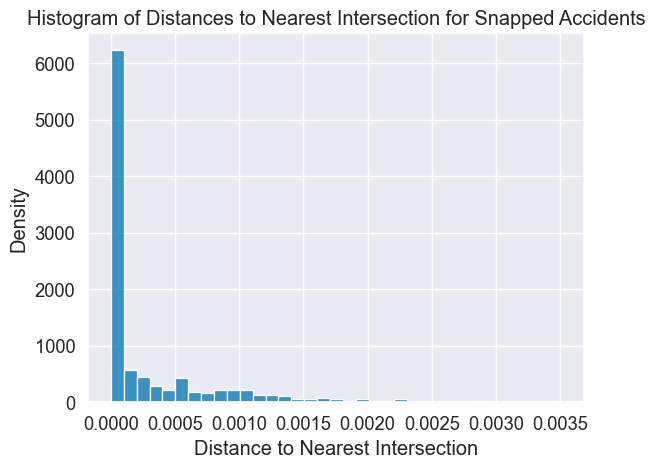

In [194]:
# Get the nearest intersection to each snapped accident
nearest_intersections = leeds_points_graph.nearestneighbordistances('accidents', snap_dist=True)

# # Get the distance between the snapped accident and the nearest intersection
distances = [x[1] for x in nearest_intersections.values()]

# print the first values from nearest_intersections
print(list(nearest_intersections.items())[:5])

# what is the maximum distance?
print("The maximum distance: ",max(distances))

# what is the minimum distance?
print("The minimum distance: ",min(distances))

# what is the mean distance?
print("The mean distance: ",np.mean(distances))

# Plot the distribution of these distances by using the relative counts
# create a histogram with seaborn
sns.histplot(distances, stat="density")

# set x-label and title
sns.set_style("whitegrid")
# sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(font_scale=1.2)
sns.set_palette("colorblind")
plt.xlabel("Distance to Nearest Intersection")
plt.title("Histogram of Distances to Nearest Intersection for Snapped Accidents")

# show the plot
plt.show()

## Organising Marathons in the area chosen

In [195]:
# get the nodes of the graph
nodes, edges = ox.graph_to_gdfs(leeds_graph)

# create kmeans object to cluster the nodes into 10 equal clusters
kmeans = KMeans(n_clusters=10, random_state=99)

# fit kmeans object to data
kmeans.fit(nodes[['x', 'y']])

/Users/mohammadmaraqa/opt/anaconda3/envs/nda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=10, random_state=99)

In [196]:

# Get the coordinates of the centroids
centroids = kmeans.cluster_centers_
cluster_assignment = kmeans.labels_

# Get node ids of the centroids
seeds = ox.get_nearest_nodes(leeds_graph, centroids[:,0], centroids[:,1])

all_nodes = list(leeds_graph.nodes)

# check if all seeds are in the graph of the area chosen
for seed in seeds:
    if seed not in all_nodes:
        print("Seed not in graph")
        
        

/Users/mohammadmaraqa/opt/anaconda3/envs/nda/lib/python3.9/site-packages/osmnx/distance.py:426: UserWarning: The `get_nearest_nodes` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)


In [197]:
# check how many seeds are in the graph of the area chosen
print((seeds))


[304904880, 964815896, 982577678, 163655028, 395498799, 762375093, 10456833, 249802001, 9270563901, 394917336]


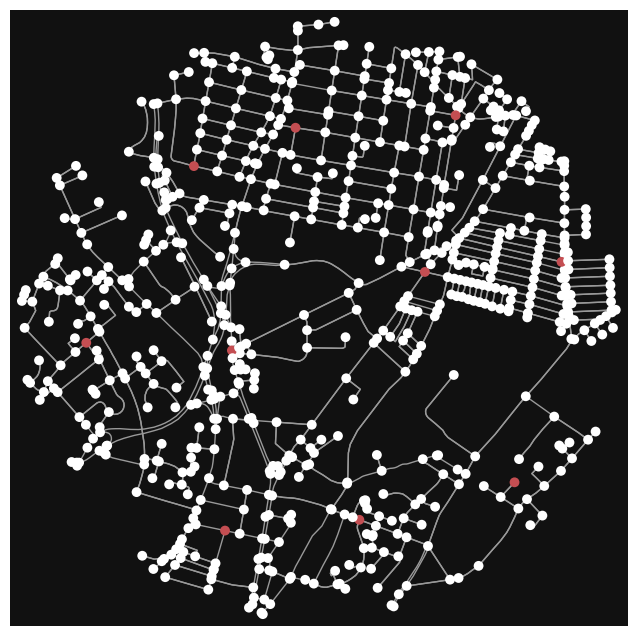

<Figure size 640x480 with 0 Axes>

In [198]:
node_colours = ['r' if node in seeds else 'w' for node in all_nodes]

# Plot the graph with the centroids
fig, ax = ox.plot_graph(leeds_graph, node_color=node_colours, node_size=50, node_zorder=2)
plt.tight_layout()
plt.show()

In [199]:

# from scipy.spatial.distance import euclidean

# # calculate Euclidean distances between nodes and seeds
# distances = {seed: {node: euclidean((leeds_graph.nodes[seed]['x'], leeds_graph.nodes[seed]['y']), 
#                                      (leeds_graph.nodes[node]['x'], leeds_graph.nodes[node]['y'])) 
#                     for node in all_nodes} 
#              for seed in seeds}

# def nearest_from_list(node_distances):
#     return sorted(node_distances, key=lambda node_length: node_length[1])[0] if len(node_distances) > 0 else None

# def nearest_seed(node):
#     seed_distances = [(seed, distances[seed][node]) 
#                       for seed in seeds if node in distances[seed]]
#     return nearest_from_list(seed_distances)

# def nearest_for_edge(edge):
#     nearest_to_ends_all = [nearest_seed(edge[0]), nearest_seed(edge[1])]
#     nearest_to_ends = [distance for distance in nearest_to_ends_all if distance]
#     return nearest_from_list(nearest_to_ends)

# colours = ox.plot.get_colors(10)

# def colour_for_seed_distance(seed):
#     return colours[seeds.index(seed[0])]

# edge_nearest_seeds = [nearest_for_edge(edge) for edge in leeds_graph.edges]
# # Note that edges not connected to a seed shown in black, so invisible on black background
# edge_colours = [colour_for_seed_distance(seed) if seed else 'k' for seed in edge_nearest_seeds]
# # For the road network nodes, we want the seeds to be coloured red and the non-seed nodes to be coloured white.
# node_colours = ['r' if node in seeds else 'w' for node in all_nodes]

# ox.plot.plot_graph(leeds_graph, edge_color = edge_colours, node_color = node_colours, bgcolor = 'k', save = False)

In [200]:
# # create a dictionary to store the nodes of each cluster
# clusters = {i: [] for i in range(10)}

# # assign each node to a cluster
# for node, label in zip(nodes.index, kmeans.labels_):
#     clusters[label].append(node)

# # calculate the shortest path for each cluster
# for i in range(10):
#     subgraph = leeds_graph.subgraph(clusters[i])
#     shortest_paths = dict(nx.all_pairs_shortest_path(subgraph))
#     # print(f"Shortest paths for cluster {i}: {shortest_paths}")


In [201]:
# #create a undirected subgraph for each cluster
# for i in range(10):
#     subgraph = leeds_graph.subgraph(clusters[i])
#     print(f"Cluster {i}: {subgraph.number_of_nodes(), subgraph.number_of_edges()}")

In [202]:
# # calculate the total length of each cluster
# for i in range(10):
#     subgraph = leeds_graph.subgraph(clusters[i])
#     total_length = sum([data['length'] for u, v, data in subgraph.edges(data=True)])
#     print(f"Total length of cluster {i}: {total_length}")

In [203]:
# #print seed for each cluster
# for i in range(10):
#     subgraph = leeds_graph.subgraph(clusters[i])
#     print(f"Seed for cluster {i}: {seeds[i]}")

# Create vornoi diagram by calculating distance using shortest path

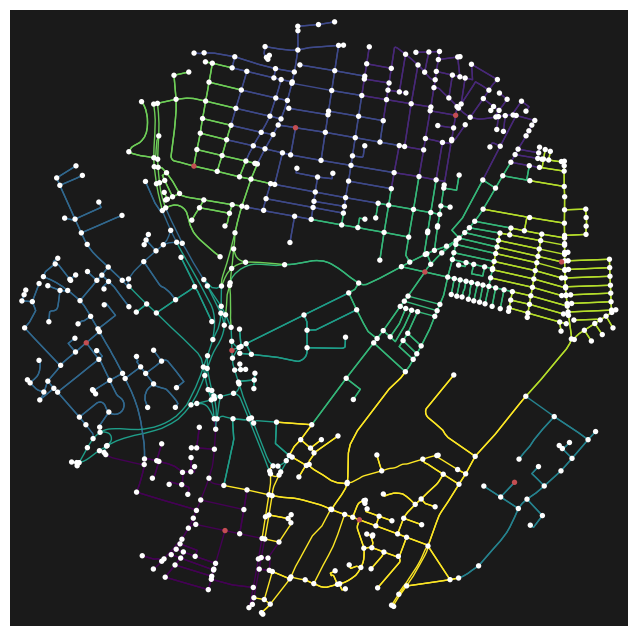

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

In [204]:
# calculate shorest path distances between nodes and seeds
distances = {seed: {node: nx.shortest_path_length(leeds_graph, source=seed, target=node, weight='length') 
                    if nx.has_path(leeds_graph, source=seed, target=node) else float('inf')
                    for node in all_nodes} 
             for seed in seeds}

# The nearest_from_list function takes a list of node distances and returns the nearest node.
def nearest_from_list(node_distances):
    return sorted(node_distances, key=lambda node_length: node_length[1])[0] if len(node_distances) > 0 else None

# The nearest_seed function takes a node and finds the seed that is nearest to it.
def nearest_seed(node):
    seed_distances = [(seed, distances[seed][node]) 
                      for seed in seeds if node in distances[seed]]
    return nearest_from_list(seed_distances)

# The nearest_for_edge function takes an edge and returns the nearest seed for each of its endpoints.
def nearest_for_edge(edge):
    nearest_to_ends_all = [nearest_seed(edge[0]), nearest_seed(edge[1])]
    nearest_to_ends = [distance for distance in nearest_to_ends_all if distance]
    return nearest_from_list(nearest_to_ends)

colours = ox.plot.get_colors(10)

# The colour_for_seed_distance function returns the colour associated with the seed.
def colour_for_seed_distance(seed):
    return colours[seeds.index(seed[0])]

# The edge_nearest_seeds variable stores the nearest seed for each edge in the graph.
edge_nearest_seeds = [nearest_for_edge(edge) for edge in leeds_graph.edges]
# The edge_colours variable stores the colours of each edge based on its nearest seed.
edge_colours = [colour_for_seed_distance(seed) if seed else 'k' for seed in edge_nearest_seeds]
# The node_colours variable stores the colours of each node in the graph.
node_colours = ['r' if node in seeds else 'w' for node in all_nodes]

# plot the graph with coloured nodes and edges.
ox.plot.plot_graph(leeds_graph, edge_color = edge_colours, node_color = node_colours, bgcolor = 'k', save = False)

In [208]:
# create a dictionary to store the nodes of each cluster
clusters = {i: [] for i in range(10)}

# assign each node to a cluster
for node, label in zip(nodes.index, kmeans.labels_):
    clusters[label].append(node)

# calculate the shortest path for each cluster
for i in range(10):
    subgraph = leeds_graph.subgraph(clusters[i])
    shortest_paths = dict(nx.all_pairs_shortest_path(subgraph))
    print(f"Shortest paths for cluster {i}: {shortest_paths}")

# calculate the total length of each cluster
for i in range(10):
    subgraph = leeds_graph.subgraph(clusters[i])
    total_length = sum([data['length'] for u, v, data in subgraph.edges(data=True)])
    print(f"Total length of cluster {i}: {total_length}")

Shortest paths for cluster 0: {250932738: {250932738: [250932738], 250932749: [250932738, 250932749], 250961842: [250932738, 250961842], 250932750: [250932738, 250932749, 250932750], 52161947: [250932738, 250961842, 52161947], 52678050: [250932738, 250932749, 250932750, 52678050], 52678401: [250932738, 250961842, 52161947, 52678401], 52161965: [250932738, 250961842, 52161947, 52161965], 52677787: [250932738, 250932749, 250932750, 52678050, 52677787], 52678071: [250932738, 250932749, 250932750, 52678050, 52678071], 304904882: [250932738, 250961842, 52161947, 52678401, 304904882], 52162260: [250932738, 250961842, 52161947, 52678401, 52162260], 250960421: [250932738, 250961842, 52161947, 52161965, 250960421], 921270404: [250932738, 250932749, 250932750, 52678050, 52677787, 921270404], 52678484: [250932738, 250932749, 250932750, 52678050, 52677787, 52678484], 304904884: [250932738, 250961842, 52161947, 52678401, 304904882, 304904884], 304904880: [250932738, 250961842, 52161947, 52678401, 5

In [206]:
# check if seed is in each cluster
for i in range(10):
    subgraph = leeds_graph.subgraph(clusters[i])
    print(f"Seed for cluster {i}: {seeds[i]}")

Seed for cluster 0: 304904880
Seed for cluster 1: 964815896
Seed for cluster 2: 982577678
Seed for cluster 3: 163655028
Seed for cluster 4: 395498799
Seed for cluster 5: 762375093
Seed for cluster 6: 10456833
Seed for cluster 7: 249802001
Seed for cluster 8: 9270563901
Seed for cluster 9: 394917336


Cluster 0: (81, 204)
Longest cycle in cluster 0: (52678401, 52162260, 304904880, 3071035464, 250961841, 3071035472, 52162388, 52167467, 52350416, 52350418, 52167573, 52167555, 52167499, 52167520, 1743296800, 52167543, 52167611, 304904907, 304904904, 26298435, 26298434, 26298438, 8674724116, 395469494, 249813619, 26298445, 26298440, 26298441, 1591373213, 395471671, 395471672, 395469497, 52162287, 52162276, 9823138, 8674727247, 395469503, 9823212, 250349453, 49556963, 10456778, 49556962, 49556960, 3071035461, 3071035459, 304904881, 304904882, 304904884, 52161965, 52161947, 52678401)
Total length of longest cycle in cluster 0: 7628.457999999993
Cluster 1: (76, 178)
Longest cycle in cluster 1: (964813697, 964813897, 964813905, 964815876, 245494214, 8978484482, 888550223, 964814272, 1778268294, 964814245, 964813713, 964813895, 964813884, 964813870, 964813881, 964813785, 982577525, 982577401, 982577369, 249806203, 249806199, 982577430, 982577353, 1906141042, 245494249, 245494220, 245494221, 

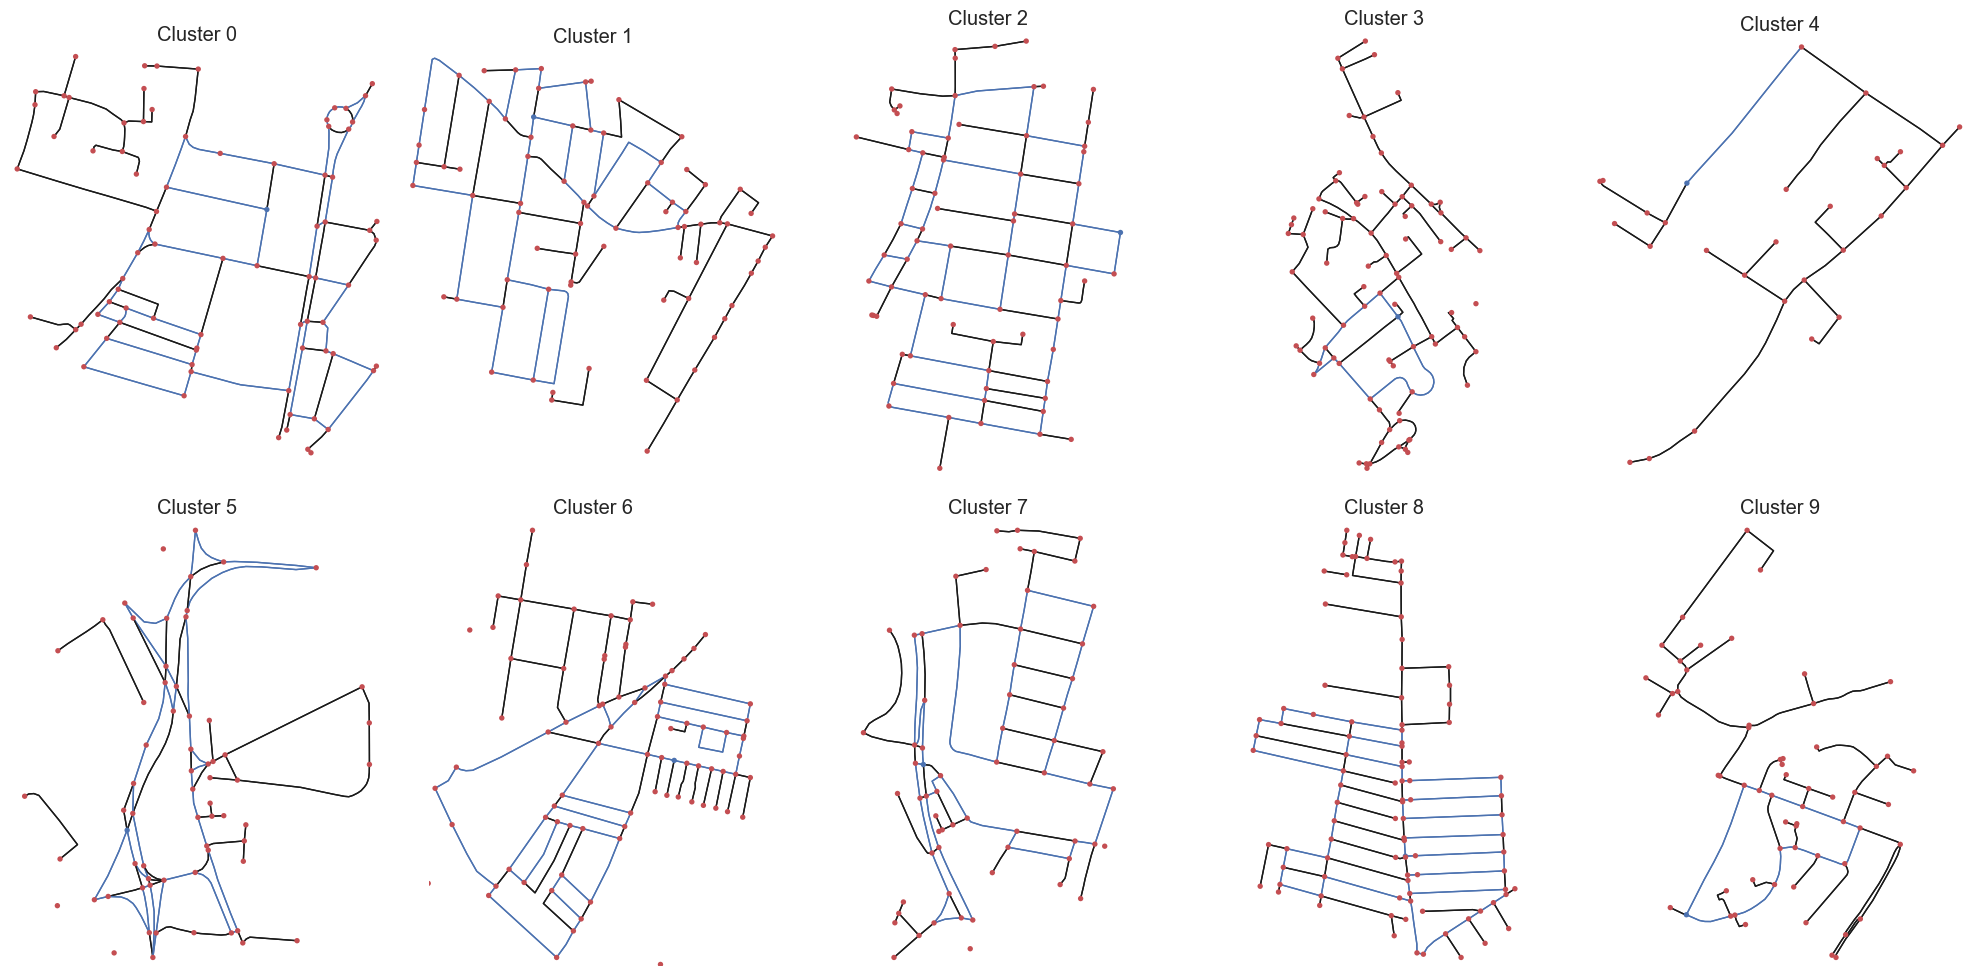

In [207]:
fig, axs = plt.subplots(2, 5, figsize=(20, 10)) # create a 2x5 subplot grid

for i in range(len(clusters)):
    undirected_leeds_graph = leeds_graph.to_undirected()
    subgraph = undirected_leeds_graph.subgraph(clusters[i])
    directed_leeds_graph = subgraph.to_directed()
    print(f"Cluster {i}: {directed_leeds_graph.number_of_nodes(), directed_leeds_graph.number_of_edges()}")

    cycles = list(nx.algorithms.cycles.simple_cycles(directed_leeds_graph))

    # ensure that cycles start and end at the same node
    for j, cycle in enumerate(cycles):
        if cycle[-1] != cycle[0]:
            cycle.append(cycle[0])
            cycles[j] = cycle

    # calculate the total length of each cycle
    cycle_lengths = {}
    for cycle in cycles:
        cycle_length = sum([data['length'] for u, v, data in directed_leeds_graph.edges(data=True) if u in cycle and v in cycle])
        cycle_lengths[tuple(cycle)] = cycle_length

    # find longest cycle
    longest_cycle = max(cycle_lengths, key=cycle_lengths.get)
    print(f"Longest cycle in cluster {i}: {longest_cycle}")

    # calculate the total length of the longest cycle
    total_length = cycle_lengths[longest_cycle]
    print(f"Total length of longest cycle in cluster {i}: {total_length}")

    # create a set of edges that are part of the longest cycle
    longest_cycle_edges = {(longest_cycle[i], longest_cycle[i+1]) for i in range(len(longest_cycle)-1)}

    # set the color of the edges that are part of the longest cycle to blue and the rest to black
    edge_colors = ['b' if (u, v) in longest_cycle_edges or (v, u) in longest_cycle_edges else 'k' for u, v in directed_leeds_graph.edges()]

    # set the color of the start and end nodes to blue
    node_colors = ['b' if node == longest_cycle[0] or node == longest_cycle[-1] else 'r' for node in directed_leeds_graph.nodes()]

    # add the plot to the subplot grid
    row = i // 5
    col = i % 5
    axs[row, col].set_title(f"Cluster {i}")
    axs[row, col].set_axis_off() # remove axis ticks and labels
    axs[row, col].set_aspect('equal') # set aspect ratio to 1:1
    ox.plot_graph(directed_leeds_graph, ax=axs[row, col], edge_color=edge_colors, node_color=node_colors, bgcolor='w', show=False)

plt.tight_layout() # improve subplot spacing
plt.show() # show the plot
